In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quick Start to Quantum Computing with CUDA-Q
# Lab 1 - Start Small: Quantum programming with one qubit
$\renewcommand{\ket}[1]{|#1\rangle}$


## Overview

This lab starts with an introduction to quantum computing by comparing it to classical computation. It specifically defines the concepts of qubits and quantum operations using both visual and mathematical representations. These two concepts are all you need to begin coding. By the end of the lab, you'll have written not just your first, but several quantum programs using CUDA-Q!

**What you'll do:**
* Define and visualize single-qubit states and operations
* Write your first quantum programs
* Interpret the results of a quantum program

**Terminology you'll use:**
* quantum state
* probability amplitudes
* superposition
* kernel
* quantum circuit
* measurement
* sample
* quasi-probability distribution
* sampling error

**CUDA-Q syntax you'll use:**
* defining a quantum kernel: `@cudaq.kernel`
* qubit initialization: `cudaq.qvector` and `cudaq.qubit`
* quantum gates: `x` and `h`
* extracting information from a kernel: `get_state`, `sample`
* visualization tools: `add_to_bloch_sphere`, `show`, `draw`





Execute the cells below to load all the necessary packages for this lab.

In [1]:
## Instructions for Google Colab. You can ignore this cell if you have cuda-q set up and have 
# all the dependent files on your system
# Run this notebook in a CPU runtime
# Uncomment the lines below and execute the cell to install cuda-q

# !pip install cudaq

# !wget -q https://github.com/nvidia/cuda-q-academic/archive/refs/heads/main.zip
# !unzip -q main.zip
# !mv cuda-q-academic-main/quick-start-to-quantum/interactive_widget ./interactive_widget

In [2]:
# install `qutip` and `ipywidgets` in the current Python kernel. Skip this if they are already installed.
# `matplotlib` is required for all visualization tasks.
# Make sure to restart your kernel if you execute this!
# In a Jupyter notebook, go to the menu bar > Kernel > Restart Kernel.
# In VSCode, click on the Restart button in the Jupyter toolbar.

# The '\' before the '>' operator is so that the shell does not misunderstand
# the '>' qualifier for the bash pipe operation.

import sys

try:
    import matplotlib.pyplot as plt
    import qutip
    import ipywidgets as widgets

except ImportError:
    print("Tools not found, installing. Please restart your kernel after this is done.")
    !{sys.executable} -m pip install qutip\>=5 matplotlib\>=3.5
    !{sys.executable} -m pip install ipywidgets
    print("\nNew libraries have been installed. Please restart your kernel!")

In [3]:
# Necessary packages

import cudaq
import numpy as np
import ipywidgets as widgets
from ipywidgets import interactive_output, HBox, VBox
from IPython.display import display, clear_output


## 1.1 Overview of Quantum Computing

Watch [this presentation](http://www.youtube.com/watch?v=gevJ5xU_WUA) to understand quantum computing fundamentals and discover the current challenges in developing practical quantum computers. You'll learn how GPUs and CUDA-Q are essential for both quantum simulation and the development of future accelerated quantum supercomputers. This overview might inspire you to continue learning how to program in CUDA-Q.

## 1.2 Define single-qubit states and operations

Computation involves storing and manipulating information. What distinguishes quantum computing from classical computing is the way in which information is represented and manipulated. We'll first review how information is represented in classical or digital computing and then contrast this with how information is represented in a quantum program. 


### 1.2.1 Classical bits

  The basic unit of information in classical computing is a *bit*. A bit stores information by taking on the value (sometimes referred to as a state) of either 0 or 1.  We can use the notation $b=0$ to describe a bit $b$ in the state $0$. One way to visualize this is an arrow (or a unit vector).  If the vector is pointing up, the bit is in the state 0 and if the vector points down, the bit is in the state 1.  Classical computing can change the state of a bit by changing it from a 0 to a 1 or vice versa. This operation is known as a bit-flip, and visually looks like flipping the direction of the vector from up to down or vice versa.

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/bits.png" alt="vectors representing bits in the state 0 and the state 1" width="200"/>

### 1.2.2 Qubits

In quantum computing, instead of bits, information is stored in *qubits*.  While a single bit can only be in one of 2 states at a given time, a single qubit can be in one of infinitely many states! This suggests that we might be able to handle information more efficiently with qubits than we could with bits.

There is a catch.  While there are infinitely many quantum states, we can't necessarily access all the information stored in these infinitely many states.  This is due to the uncertainty principle in quantum mechanics. Restricting our focus on how uncertainty arises in quantum computation, let's look at the general structure of a quantum program. Many quantum programs start with initializing a quantum state, manipulating the state, and then measuring it.  When we measure a qubit, the act of measuring can change the quantum state of the qubit. For example, measuring may collapse the quantum state of a single qubit to one of two classical states (e.g., 0 or 1). Measurement is how we extract useful information from a qubit. We'll explore this idea later in the notebook.

To visualize qubits, we will extend the idea of representing a bit as a unit vector pointing up or down. A qubit can be thought of as a unit vector pointing in any direction in 3D.  In other words, we can visualize a qubit as a vector on a sphere. The literature refers to this sphere as the Bloch sphere.  As a generalization of bits, we'll identify the vector pointing up (i.e., in the direction of the positive $z$-axis) with the zero state (see figure below). 

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/Blochsphere0.png" alt="Bloch sphere representation of \ket{0}" width="200"/>

The zero state is denoted by $\ket{0}$ and this notation is read as "ket zero" or "zero ket". The word "ket" comes from Dirac notation, which we'll describe in more detail later. The vector pointing down will represent the one state, which is abbreviated as $\ket{1}$ and referred to as "ket one" or "one ket". 

In addition to the $\ket{0}$  and $\ket{1}$ states, there are infinitely many other quantum states.  Each of the infinitely many vectors on the Bloch sphere represents a different state.


<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/BlochsphereManyStates.png" alt="Several states represented on the Bloch Sphere" width="200"/>

Execute the code block below to generate a widget that you can interact with to visualize rotating the $\ket{0}$ state about the $X$, $Y$, and $Z$ axis, in that order, by angles $\theta_X$, $\theta_Y$, and $\theta_Z$, respectively. You can control the sliders with your mouse, or type in a value in the box to the right of the slider. For now, do not concern yourself with the code itself.  We'll explain it in due time. For now, think of it as a preview to CUDA-Q.  How many different quantum states can you generate starting with the $\ket{0}$ state and just using rotations about the $X$, $Y$, and $Z$ axis?

In [4]:
# Execute this cell to enable the interactive widget

import sys
sys.path.append('interactive_widget')
from bloch_sphere_rotation import create_rotation_widget

# Create and display a new widget
widget = create_rotation_widget()
display(widget)


None

>**FAQ:** *How does "infinitely many states" of a qubit differ from "analog computing"? That is also infinite, no?*  

>**Answer** Qubits can demonstrate the quantum properties of superposition, entanglement, and interference. Additionally, in analog computing, the way in which information is extracted from an analog state differs from what happens in quantum computing.  This is due to the way states are measured and the limitations imposed by the uncertainty principle in quantum mechanics.  We'll experiment with measurement and superposition in this notebook. Entanglement and interference are covered in the next notebook. 

Now that we have a visual representation of a qubit, let's establish some notation that will allow us to describe states and carry out quantum operations on these states.  We've already introduced the states $\ket{0}$ and $\ket{1}$.  We can identify $\ket{0}$ with the vector $\begin{pmatrix} 1 \\ 0\end{pmatrix}$ and $\ket{1}$ with the vector $\begin{pmatrix} 0\\ 1\end{pmatrix}$.  Then, for the purposes of this tutorial, any other quantum state $\ket{\psi}$ on the Bloch sphere can be written as a linear combination of $\ket{0}$ and $\ket{1}$ .  In other words, quantum states take the form

$$
\ket{\psi} = \alpha\ket{0}+\beta\ket{1},
$$

where $\alpha$ and $\beta$ are complex numbers satisfying the equation $|\alpha|^2+|\beta|^2 = 1$. The coefficients $\alpha$ and $\beta$ are referred to as *probability amplitudes*, or *amplitudes* for short. The restriction that $|\alpha|^2+|\beta|^2 = 1$ ensures that the state is on the Bloch sphere.

Let's see how the expression $
\ket{\psi} = \alpha\ket{0}+\beta\ket{1},
$ maps to the Bloch sphere. First, we rewrite the coefficients $\alpha$ and $\beta$ in the following manner:

$$
\alpha = \cos(\frac{\theta}{2})\text{ and }\beta = \sin(\frac{\theta}{2})e^{i\varphi}, 
$$
where $\theta$ is a value in the interval $[0,\pi]$ and $\varphi$ is a value in the interval $[0,2\pi)$. Using spherical coordinates we can draw the state on the Bloch sphere following the convention in the image below:

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/BlochsphereAngles.png" alt="Image of a State on the Bloch Sphere with spherical coordinates indicated" width="200"/>

Execute the cell block below to open up an interactive tool to visualize $\ket{\psi} = \cos{\frac{\theta}{2}}\ket{0}+\sin{\frac{\theta}{2}}e^{i\varphi}\ket{1}$ for various values of $\theta$ and $\varphi$.  As you experiment, think about the following questions: What effect does changing $\varphi$ have on the position of the vector on the Bloch Sphere?  What combination of values of $\theta$ and $\varphi$ produces a state pointing along the $x$-axis?

In [5]:
# Execute this cell to visualize the state |ψ⟩ = cos(θ/2)|0⟩ + sin(θ/2)e^{iφ}|1⟩ on the Bloch Sphere
import sys
sys.path.append('interactive_widget')
from bloch_sphere_state_visualization import create_state_widget

# Create and display a new widget
widget = create_state_widget()
display(widget)


HTML(value='<h3>Visualize the State |ψ⟩ with Varying Angles θ and φ (in radians)</h3>')

None

For example, the state $$\ket{-} = \frac{1}{\sqrt{2}}\ket{0}-\frac{1}{\sqrt{2}}\ket{1}$$ can be rewritten as 
$$
\ket{-} = \cos(\frac{\pi}{4})\ket{0}+\sin(\frac{\pi}{4})e^{i\pi}\ket{1},
$$
where $\theta = \frac{\pi}{2}$ and $\varphi = \pi$.
For an explanation of how $\theta$ and $\varphi$ are found in general, check out this [source](https://davidmeyer.github.io/qc/bloch_sphere.pdf).
Once we have found $\theta$ and $\varphi$, we can draw the state on the Bloch sphere. In particular, the state $\ket{-}$ is a vector pointing in the direction of the negative $x$-axis, which gives some explanation for the jargon: "minus state."

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/BlochsphereMinus.png" alt="Minus state represented on the Bloch Sphere" width="200"/>


> **Take note:** In order to do any computation, we will need a mechanism for changing the state of a qubit.  Quantum computing allows us to change the state of a single qubit through quantum operations which can be visualized as rotations of the sphere. We'll explore this in more detail later in this notebook.  



### 1.2.3 Using CUDA-Q to define and visualize a quantum state

We are now ready to use CUDA-Q! 

> **FAQ:** *What is CUDA-Q?*

> **Answer:** [CUDA-Q](https://developer.nvidia.com/cuda-q) is a platform designed for hybrid application development. That is, CUDA-Q allows programming in a heterogeneous environment that leverages not only quantum processors and quantum emulators, but also CPUs and GPUs. CUDA-Q is interoperable with CUDA and the CUDA software ecosystem for GPU-accelerated applications. CUDA-Q consists of both C++ and Python extensions. In these notebooks, we'll use Python. 

 Let's use CUDA-Q to create the quantum states of single qubits and visualize them on the Bloch sphere.  CUDA-Q uses the `cudaq.kernel` decorator on functions to define quantum states, and, as we will see later, CUDA-Q kernels can also define quantum circuits.  

In [6]:
# Defining the minus state in CUDA-Q

# First we define a vector of complex numbers
# for the coefficients alpha and beta
# of the state |psi> = alpha|0> + beta|1>, 
# where alpha = 1/sqrt(2)+0j and beta = -1/sqrt(2)+0j
c = [complex(np.sqrt(2)/2, 0), complex(-np.sqrt(2)/2,0)]
 
# Define a cudaq.kernel to represent the minus state
@cudaq.kernel
def minus_state():
    q = cudaq.qvector(c)


Once we have defined a kernel, we can call upon the `get_state` command to read out the state from the kernel.  Then, we can add this state to a Bloch sphere using `add_to_bloch_sphere` which is displayed with the `show` command and the file can be saved using the `save` option. 

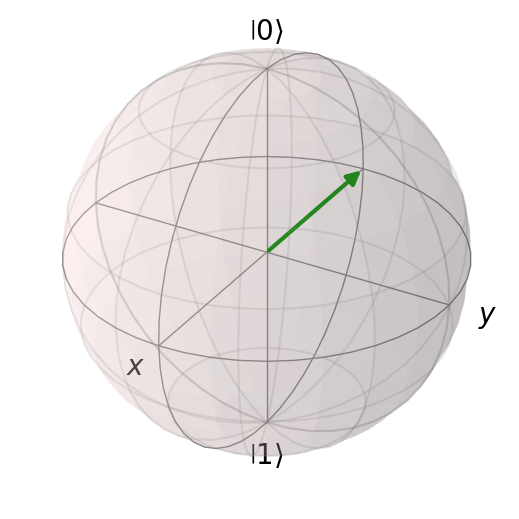

In [7]:
# Visualizing a state in CUDA-Q

# Define a sphere object representing the state of the single qubit
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(minus_state))

# Display the Bloch sphere
cudaq.show(sphere)

# Save the Bloch sphere image to a file
sphere.save('MinusState.png')


**Exercise 1:**  Create a Bloch sphere showing the states: $\ket{0}, \ket{1}, \ket{+}$, and $\ket{i} = \frac{1}{\sqrt{2}}\ket{0}+\frac{i}{\sqrt{2}}\ket{1}$.

Hint: $e^{i\pi} = -1$ and $e^{i\frac{\pi}{2}}=i$.

>**CUDA-Q Quick Tip:** The `add_to_bloch_sphere` command can accept a single state as we demonstrated above, or a list of states that can be graphed in an array of separate Bloch spheres. You can read more about this visualization tool [here](https://nvidia.github.io/cuda-quantum/latest/examples/python/visualization.html).

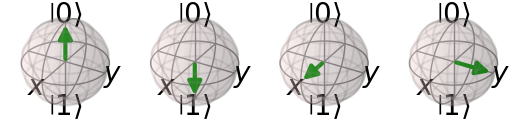

In [8]:
# EXERCISE 1

# First we define vectors for the coefficients alpha and beta
# of the states |0>, |1>, |+>, and |i>, where each state is written
# in the form |psi> = alpha|0> + beta|1> . Here alpha and beta are
# of the form:
# alpha = a_real + (a_imaginary)i 
# beta = b_real + (b_imaginary)i 
# with real values for the coefficients 
# a_real, a_imaginary, b_real, b_imaginary 

# c0 is a list of complex coefficients for the state |0>
c0 = [complex(1, 0), complex(0, 0)] ###FIX_ME### 
c1 = [complex(0, 0), complex(1, 0)] ###FIX_ME###      # list of complex coefficients for the state |1>
c2 = [complex(1/np.sqrt(2), 0), complex(1/np.sqrt(2), 0)]      # list of complex coefficients for the state |+>
c3 = [complex(1/np.sqrt(2), 0), complex(0, 1/np.sqrt(2))] ###FIX_ME###      # list of complex coefficients for the state |i>

list_of_states = [c0,c1,c2,c3]

# Define a cudaq.kernel to represent the state with given coefficients
@cudaq.kernel
def kernel_for_state(c:list[complex]):
    q = cudaq.qvector(c)

# Define a list of Bloch spheres, one sphere for each of the 4 states 
blochSphereList = []  
# Generate the 4 states by calling the kernel_for_state kernel for each list of coefficients
for c in list_of_states:
    sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(kernel_for_state, c))
    blochSphereList.append(sphere)  

# Display the Bloch spheres side by side in 2 rows and 2 columns
cudaq.show(blochSphereList, nrows=1, ncols=4)

## 1.3 Writing your first quantum programs

Now that we understand qubits and have created quantum state representations in CUDA-Q, let's move on to actual quantum computation. We're ready to write our first quantum program!

The general structure of a quantum program is:
* Encode information into the quantum state by initializing qubit(s)
* Manipulate the quantum state of the qubit(s) with quantum gate(s)
* Extract information from the quantum state by measuring the state of the qubit(s)

These three steps are outlined in the diagram below:

<img src="https://raw.githubusercontent.com/NVIDIA/cuda-q-academic/main/images/circuit.png" alt="image of a quantum circuit with the three partsL encode information, manipulate quantum states, extract information" width="200"/>

In this section, we'll look at a few simple examples of quantum programs to illustrate these steps.  Throughout the notebook, we'll apply this template to generate and run more interesting examples.  Let's begin with two very simple quantum programs: a bit flip program and a Hello World program. Through these examples, you'll learn about two other important concepts: measurement and superposition.


### 1.3.1 Bit Flip

Let's walk through the three steps of writing the Bit Flip program in CUDA-Q. This program is a quantum version of the classical `NOT` operation that flips a bit from $0$ to $1$ and vice versa.

Outline of the Bit Flip program: Going from $\ket{0}$ to $\ket{1}$.
* Initialize the zero state
* Manipulate the quantum state by applying the bit flip gate (the `x` gate)
* Measure the qubit

Let's start by defining a kernel and specifying that this kernel only contains one qubit.  

> **CUDA-Q Quick Tip:**  The `cudaq.qvector` command has two purposes.  When `cudaq.qvector` accepts a `list` as we saw in the `minus_state` example in the previous section, the kernel is initialized in the state corresponding to the coefficients from the list.  In the example below, `cudaq.qvector` will accept an `int` value and will allocate that number of qubits to the kernel.  These qubits, by default, are initialized in the zero-state.

In [7]:
# Writing a bit flip program one step at a time
# Step 1: Create a kernel with one qubit initialized in the zero state

@cudaq.kernel
def bitflip(): 
    # Allocate one qubit to the kernel. It is by default initialized in the zero state
    qubit = cudaq.qvector(1)
    
    # Manipulate the quantum state by applying the bit flip gate (the `x` gate)
    # To be completed later in this section
    
    

Let's check to see that the code above initiated a qubit in the zero state by getting the state and plotting it on the Bloch sphere.

In [ ]:
# Visualizing a state of the bitflip kernel before the x gate is applied

# Define a sphere object representing the state of the single qubit
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(bitflip))

# Display the Bloch sphere
cudaq.show(sphere)

Next we want to manipulate the zero state, $\ket{0}$, and change it to the one state, $\ket{1}$.  One way of doing this is by rotating the Bloch sphere 180 degrees around the x-axis.  Mathematically, this can be carried out through matrix multiplication.  Recall that $\ket{0}=\begin{pmatrix}1\\0\end{pmatrix}$ and $\ket{1}=\begin{pmatrix}0\\1\end{pmatrix}$. Notice that the matrix $X=\begin{pmatrix}0 & 1 \\ 1 & 0 \end{pmatrix}$ has the property that we're looking for.  Namely, multiplying the zero state by $X$ returns the one state: $$X\ket{0} = \ket{1}.$$  

In general, we can change a quantum state through multiplication by a unitary matrix. (The definition of a unitary matrix is not critical for this notebook, but if you're curious you can learn more in [chapter 1 of Quantum Computer Science](http://mermin.lassp.cornell.edu/qcomp/CS483.html).) In the context of a quantum program, we refer to matrix multiplication by a unitary matrix $U$ as applying a $U$-gate.   In CUDA-Q, the $X$-gate is implemented with the syntax `x`. 

> **CUDA-Q Quick Tip:** You can view all the built-in quantum gate operations in CUDA-Q [here](https://nvidia.github.io/cuda-quantum/latest/api/default_ops.html#unitary-operations-on-qubits).

Let's go ahead and apply the `x`-gate to the qubit in our kernel.



In [9]:
# Writing a bit flip program one step at a time
# Step 2: Apply the X-gate

@cudaq.kernel
def bitflip(): 
    # Allocate 1 qubit initialized in the zero state
    qubit = cudaq.qvector(1)
    
    # Manipulate the quantum state by applying the bit flip gate (the `x` gate)
    x(qubit[0]) # Apply the x-gate to the first qubit, which is indexed with 0
  
   

Let's use the `get_state` command again to check that the `bitflip` kernel does what we expect, that is, change the state from $\ket{0}$ to $\ket{1}.$

In [ ]:
# Visualizing the action of the bitflip kernel

sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(bitflip))
cudaq.show(sphere)

The process of visualizing the state of a kernel on a Bloch sphere using `get_state` is not very efficient and won't be useful when we have many qubits. Firstly, Bloch spheres can only represent the state of a single qubit.  But also, the `get_state` command may be overkill for the amount of information we can or need to recover from several qubits.  As we'll see in the next lab, to describe the state of $n$ qubits we need to compute $2^n$ probability amplitudes. This may be prohibilitively expensive to compute in terms of time and memory resources.

Fortunately, there are other visualization tools that we can use to check the kernels that we create.  Some kernels can be represented as
quantum circuit diagrams. CUDA-Q includes the `cudaq.draw` command to generate an ascii image of the circuit diagram of a kernel.  Basically, each row of the circuit diagram represents a qubit. In this case, we only have one qubit, which by default is named `q0` in the diagram. Operations applied to the qubit are shown as boxes and are read from left to right. Our kernel has only one gate, the `x` gate. We'll discuss these diagrams in more detail later after we've seen a few other examples.

In [11]:
# Drawing the circuit representation of the bit flip kernel 
    
print(cudaq.draw(bitflip))

     ╭───╮
q0 : ┤ x ├
     ╰───╯



> **FAQ:** *What's the difference between a quantum kernel and a quantum circuit?* 

> **Answer:** Quantum kernels are more general than quantum circuits.  That is, every quantum circuit is a quantum kernel, but not every quantum kernel is a quantum circuit. Quantum kernels are defined as functions that are executed on a quantum processing unit (QPU) or a simulated QPU. Quantum kernels can be combined with classical functions to create quantum-classical applications that can be executed on a heterogeneous system of QPUs, GPUs, and CPUs to solve real-world problems.

The final step of our first quantum program is to extract information from the quantum state of the qubit.  This is done with the `sample` command. The sample command runs the kernel and takes a measurement `shots_count`-many times 

In our example, applying the `x`-gate to the zero state will always result in the one state, unless of course there are errors in the circuit execution.  That's a topic for another day.  Now, we'll assume that all of our kernel executions are error free.  In this case, we would expect to see the one state returned for each kernel execution. Run the cell block below to see the results.

In [ ]:
# Sampling the bit flip kernel
shots = 123
results = cudaq.sample(bitflip, shots_count=shots)

# The output of the sample command looks like a dictionary, but is of a different type
print("Results from sampling {} times: {}\n".format(shots, results))
print("Although the results appear to be of type dict, \n the type of the results from the sample \n command is {}.\n".format(type(results)))

# Often it will be useful to identify the most probable outcome
# and the probability of this outcome
most_probable_result = results.most_probable()
probability = results.probability(most_probable_result)
print("Most probable result: " + most_probable_result)
print("Measured with probability " + str(probability), end='\n\n')


You may notice that the result of executing the `bitflip` kernel is a (classical) $1$, which is technically a different type than the quantum state $\ket{1}$.  Let's look at the Hello World example below which will help illustrate what is going on with the `sample` command and how information is extracted from a quantum state.

> **CUDA-Q Quick Tip:** 
The `sample` command runs the kernel and takes a measurement `shots_count`-many times. The result of the `sample` command is a `SampleResult` dictionary of the distribution of the bitstrings resulting from the sampling. 
To create a standard Python dictionary of type dict from an object (say `sample_results`) of type `cudaq.SampleResult`, you can use a command such as `asDict = {k:v for k,v in sample_results.items()}`.

### 1.3.3 Hello World example

To get a better appreciation how quantum programs differ from classical programs, let's look at a Hello World program, which revisits the minus state kernel and will give us the opportunity to discuss two important concepts: superposition and measurement.

Hello World: Generate and measure the Minus State
* Initialize one qubit in the one-state
* Manipulate the quantum state by transforming it into the minus state 
* Extract information from the quantum state by taking measurement(s)

We already created a kernel (`minus_state`) to initialize the minus state by passing a list of coefficients to the `cudaq.qvector` command.  There are other ways to initialize a state if we know the gate operations that generate it. The Hadamard operator applied to $\ket{1}$ generates the state $\ket{-}$. 

The Hadamard operator is the matrix $$H =  \frac{1}{\sqrt{2}}\begin{pmatrix} 1&  1 \\ 1 &  -1\end{pmatrix}.$$

Notice that if we multiply $H$ and $\ket{1}$ we get $\ket{-}$:  

$$ H\ket{1} =  \frac{1}{\sqrt{2}}\begin{pmatrix} 1&  1 \\ 1 &  -1\end{pmatrix}\begin{pmatrix} 0 \\ 1 \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\   -1\end{pmatrix} = \ket{-}.$$

This calculation suggests a way to generate the minus state: 

* First intialize the one state and then apply the Hadamard gate using the CUDA-Q command `h`.  
* This leaves the question: how do we initialize the one state? The answer is implicit in the previous example: apply the `x`-gate to the zero-state.  

We now have a plan, so let's code it up.

In [10]:
# Kernel for the minus state

@cudaq.kernel
def minus_kernel():
    # Allocate a qubit
    qvector = cudaq.qvector(1)
    
    # Initialize the state |1>
    x(qvector)
    
    # Apply the Hadamard gate
    h(qvector)
    
# Draw the circuit to check our work
print(cudaq.draw(minus_kernel))

     ╭───╮╭───╮
q0 : ┤ x ├┤ h ├
     ╰───╯╰───╯



**EXERCISE 2**: Edit the code block below to check your work by graphing the Bloch sphere of the state generated by `minus_kernel`.

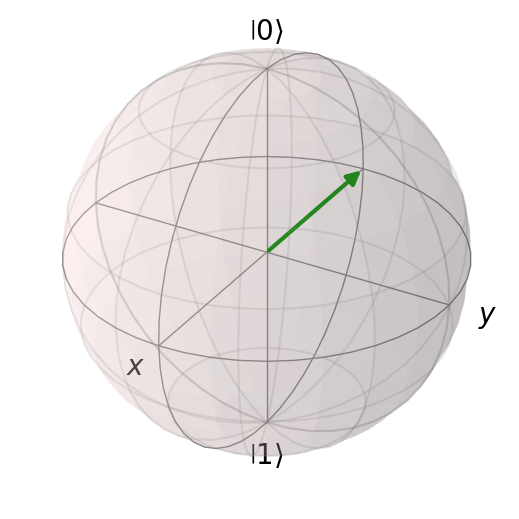

In [11]:
# EXERCISE 2

# Visualizing the action of the minus_kernel

sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(minus_kernel)) ##FIX_ME##
cudaq.show(sphere)

Let's sample the `minus_kernel` and examine the results.

In [15]:
# Sampling the minus kernel
shots = 10000
results = cudaq.sample(minus_kernel, shots_count=shots)
print("Results from sampling {} times: {}".format(shots, results))

# Often it will be useful to identify the most probable outcome
# and the probability of this outcome
most_probable_result = results.most_probable()
probability = results.probability(most_probable_result)
print("Most probable result: " + most_probable_result)
print("Measured with probability " + str(probability), end='\n\n')

Results from sampling 10000 times: { 0:5062 1:4938 }

Most probable result: 0
Measured with probability 0.5062



Notice how these results differ from what we saw in the Bit Flip program.  We'll investigate what is going on in this example in more detail in the following section.

## 1.4 Interpret the results of a quantum program

### 1.4.1 Born's Rule

Let's further explore the `minus_kernel` example from the previous section to better understand the `sample` command.  We've copied the codeblock from the previous section here, but we've edited the `shots` variable to equal $1$. Execute the cell block below a couple of times and see if you notice anything.


In [16]:
# Sampling the minus kernel
shots = 1
results = cudaq.sample(minus_kernel, shots_count=shots)
print("Results from sampling {} time: {}".format(shots, results))


Results from sampling 1 time: { 0:1 }




 What do you notice when you run this code block a couple of times?  The result varies.  This is because quantum systems are inherently probabilistic in nature.  You might see that roughly half of the time the outcome will be $0$ and the remaining times, the outcome will be a $1$.  This non-deterministic behavior can be explained by *Born's Rule*.    
 
 **Born's Rule** roughly states that if a qubit is in the quantum state $\ket{\psi}=\alpha\ket{0}+\beta\ket{1}$ with $\alpha$ and $\beta$ complex values satisfying $|\alpha|^2+|\beta|^2 = 1$, then when measured, the outcome will be $0$ with probability $|\alpha|^2$ and $1$ with probability $|\beta|^2$. Furthermore upon measurement, the state of the qubit collapses; that is, the state of the qubit will change to $\ket{0}$ if a $0$ is measured and the qubit will change to $\ket{1}$ if a $1$ is measured.

 Explore the connection between the Bloch Sphere representation of the state $\ket{\psi}$ and the probabilities of measuring a 0 or 1.  What effect does changing the angle $\phi$ have on the probability amplitudes?

In [17]:
# Execute this cell to visualize Born's Rule for the state |ψ⟩ = cos(θ/2)|0⟩ + sin(θ/2)e^{iφ}|1⟩ along with its Bloch sphere representation
import sys
sys.path.append('interactive_widget')
from borns_rule import create_borns_rule_widget

# Create and display a new widget
widget = create_borns_rule_widget()
display(widget)

None

**Exercise 3:** Based on Born's rule, what do you expect the probability of measuring the minus state as $0$ to be?  How does this compare to the results of your execution of the `minus_kernel` in the cell block above?  You might notice that the percentage of times you measure a $0$ is close, but not exactly equal to what Born's rule would predict.  Edit the `###FIX_ME###` line in the code block below to achieve sampling results more closely equal Born's rules prediction.

*Hint*: Think about the [Central Limit Theorem for Proportions](https://2012books.lardbucket.org/books/beginning-statistics/s10-03-the-sample-proportion.html) from statistics. What do you notice as you increase the number of shots?

In [20]:
# EXERCISE 3
# Sampling the minus kernel
shots = 1000000 ###FIX_ME###
results = cudaq.sample(minus_kernel, shots_count=shots)
print("Results from sampling {} times: {}".format(shots, results))

# Often it will be useful to identify the most probable outcome
# and the probability of this outcome
most_probable_result = results.most_probable()
probability = results.probability(most_probable_result)
print("Most probable result: " + most_probable_result)
print("Measured with probability " + str(probability), end='\n\n')

Results from sampling 1000000 times: { 0:499854 1:500146 }

Most probable result: 1
Measured with probability 0.500146



### 1.4.2 Superposition

The concept that distinguishes the Bit Flip program from the Hello World program is superposition.  

**Superposition** is one of the fundamental concepts in quantum mechanics that differentiates quantum computation from classical computation.  A state $\ket{\psi}=\alpha\ket{0}+\beta\ket{1}$ is in superposition, if both $\alpha$ and $\beta$ are non-zero.  In other words, $\ket{\psi}$ has a non-zero probability of being measured as a $0$, but also a non-zero probability of being measured as a $1$.  It's important to note that if a qubit is in a state of superposition, when it is measured, it will collapse to either $\ket{0}$ or $\ket{1}$ and will no longer be in superposition.

The $\ket{-}$ state that we examined in the previous section is a state in superposition with the likelihood of measuring a $0$ to be $50\%$ and the likelihood of measuring a $1$ to be $50\%$.  There are other states that are distinct from $\ket{-}$ that are also in a state of equal superposition.  Let's take a look at one of those, the plus state (i.e., $\ket{+}$). In addition to creating and sampling a kernel for the plus state in the code block below, we've used this example to illustrate two other CUDA-Q programming tips:

>**CUDA-Q Quick Tip:** When allocating just one qubit, you can use `qubit()` in place of `qvector(1)`.

>**CUDA-Q Quick Tip:** By default, when not specified, qubit measurements are conducted on the standard computational basis, which is along the $z$-axis.  In the cell block below, we have added the measurement explicitly with the `mz` command. There are other measurement options `mx` and `my` built into CUDA-Q that we'll experiment with in the next section.

In [ ]:

# Kernel for the plus state
@cudaq.kernel
def plus_kernel():
    
    # Allocate a qubit
    # Initialize the state |0>
    one_qubit = cudaq.qubit()    
    # Apply the Hadamard gate
    h(one_qubit)
 
    # Specify the measurement
    mz(one_qubit)
    
    
# Draw the circuit to check our work
print(cudaq.draw(plus_kernel))

# Sampling the minus kernel
shots = 1000
results = cudaq.sample(plus_kernel, shots_count=shots)
print(results)

# Often it will be useful to identify the most probable outcome
# and the probability of this outcome
most_probable_result = results.most_probable()
probability = results.probability(most_probable_result)
print("Most probable result: " + most_probable_result)
print("Measured with probability " + str(probability), end='\n\n')


### 1.5 More about Measurement (optional)

How do the results of sampling the `plus_kernel` compare to those obtained for the `minus_kernel` in the previous section?  What does this seem to apply concerning our ability to distinguish $\ket{+}$ from $\ket{-}$?  

If qubits store information, we would like to be able distinguish two qubits that might be storing different information. For example we might want to distinguish the one-qubit state $\ket{+}$ from the state $\ket{-}$. We'll resolve this issue in the next example by changing the way we measure the two qubits.

**Exercise 4:** Create two quantum kernels to sample.  The first will prepare the $\ket{+}$ state and then measure with `mx`.  The second kernel will prepare the $\ket{-}$ state and then measure with `mx`.  

In [24]:
# EXERCISE 4

shots = 1000

@cudaq.kernel
def plus_measure_x():
    ## EDIT CODE BELOW THIS LINE
    # Initialize the state |0>
    one_qubit = cudaq.qubit()    
    # Apply the Hadamard gate
    h(one_qubit)
 
    # Specify the measurement
    mx(one_qubit)    

    
    ## EDIT CODE ABOVE THIS LINE

@cudaq.kernel
def minus_measure_x():
    ## EDIT CODE BELOW THIS LINE
    # Allocate a qubit
    qvector = cudaq.qvector(1)
    
    # Initialize the state |1>
    x(qvector)
    
    # Apply the Hadamard gate
    h(qvector)    
    mx(qvector)  
    ## EDIT CODE ABOVE THIS LINE
    
results_plus_measure_x = cudaq.sample(plus_measure_x, shots_count=shots)
print("Results from sampling the plus_hadamard kernel {} times: {}".format(shots, results_plus_measure_x))

results_minus_measure_x = cudaq.sample(minus_measure_x, shots_count=shots)
print("Results from sampling the minus_hadamard kernel {} times: {}".format(shots, results_minus_measure_x))

Results from sampling the plus_hadamard kernel 1000 times: { 0:1000 }

Results from sampling the minus_hadamard kernel 1000 times: { 1:1000 }



Notice that the results dictionaries from sampling the $\ket{+}$ and $\ket{-}$, respectively differ from one another.  And thus, by switching to measurement with the `mx` command we are able to distinguish these two states. However, there is a drawback &#8212; measuring with `mx` doesn't allow us to distinguish $\ket{0}$ from $\ket{1}$, because of the Uncertainty Principle in quantum mechanics. Test this claim out for yourself by creating and sampling kernels for the $\ket{0}$ and $\ket{1}$ states using the `mx` measurements.

What is happening when we take a measurement?  What distinguishes the `mz` command from the `mx` command?  Abstractly when we are measuring a state $\ket{\psi}=\alpha\ket{0}+\beta\ket{1}$ with `mz`, we are applying Born's rule to the state $\ket{\psi}$. This act of measurement will collapse the state to $\ket{0}$, with a probability $|\alpha|^2$  and will collapse the state of the qubit to  $\ket{1}$ with probability $|\beta|^2$. You can graphically visualize this collapse under a `mz` measurement on the Bloch sphere as projecting the state $\ket{\psi}$ onto the $z$ axis.  

Analogously, when measuring with `mx` we will be collapsing our state $\ket{\psi}$ to either $\ket{+}$ or $\ket{-}$ along the $x$-axis of the Bloch sphere.  We can use Born's Rule for this measurement, too.  The only difference is now instead of writing $\ket{\psi}$ in terms of computational basis states $\ket{0}$ and $\ket{1}$, we'll find coefficients $\gamma$ and $\delta$ so that $\ket{\psi}=\gamma\ket{+}+\delta\ket{-}$. With the `mx`measurement, the probabilities of measuring a $0$ and $1$ are determined by $|\gamma|^2$ and $|\delta|^2$, respectively. 
So for the case of $\ket{+}$, the probability of measuring $0$ with `mx` is $100\%$, and for $\ket{-}$ the probability of measuring a $1$ with `mx` is $100\%$. Therefore, `mx` gives us a way to distinguish $\ket{+}$ and $\ket{-}$ with only one shot, assuming there is no noise.

For the remainder of this series of labs, we'll only be measuring with `mz`. To learn more about measurement, check out [chapter 4 of Introduction to Quantum Information Science](https://qubit.guide/4.1-hilbert-spaces-briefly) or [section 2.2.3 of Introduction to Classical and Quantum Computing](https://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e4p.pdf).

## Next

There's not a whole lot we can do with just one qubit.  In fact, one of the fundamental quantum properties (entanglement) requires more than one qubit.  Let's move to Lab 2, where we start programming with more than one qubit and learn about entanglement.